In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from scipy import stats
import math

base_path = 'data/project/'

In [2]:
def read(file_name,base_path=base_path):
    return pd.read_csv(f'{base_path}/{file_name}')

def provideStats(df, *, columns = None, confidence=0.95):
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns[1:]
    else:
        cols = pd.Index(columns)

    if len(cols) == 0:
        raise ValueError("No numeric columns to summarise.")

    out_rows = []
    for col in cols:
        s = df[col].dropna()
        n = len(s)
        if n == 0:
            # no data: fill with NaNs
            out_rows.append((np.nan, np.nan, np.nan, np.nan))
            continue

        mean     = s.mean()
        var      = s.var(ddof=1)             # sample variance
        ci_low, ci_high = st.t.interval(
            confidence, n - 1, loc=mean, scale=st.sem(s, nan_policy="omit")
        )
        out_rows.append((mean, var, ci_low, ci_high))

    result = pd.DataFrame(
        out_rows,
        index=cols,
        columns=["mean", "variance", "ci_lower", "ci_upper"],
    )

    return result

def plotData(df, *, close_existing=True):

    if close_existing:
        plt.close('all')           # prevents accidental “ghost” figures

    # keep only numeric columns (strings, categoricals, objects are ignored)
    cols = [c for c in df.columns if is_numeric_dtype(df[c])][1:]
    if not cols:
        raise ValueError("No numeric columns to plot.")

         # one figure, one set of axes
    plt.figure(figsize=(10,6))
    for col in cols:
        plt.plot(df.index, df[col], label=col,)

    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plotCorrelation(df, *, close_existing=True):
    if close_existing:
        plt.close('all')

    # isolate numeric columns
    num_cols = [c for c in df.columns if is_numeric_dtype(df[c])][1:]
    if len(num_cols) < 2:
        raise ValueError("Need at least two numeric columns to compute correlations.")

    # --- 1. Correlation heat-map -------------------------------------------
    corr = df[num_cols].corr()
    fig_hm, ax_hm = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax_hm)
    ax_hm.set_title("Correlation matrix")
    fig_hm.tight_layout()

    # --- 2. Pair-plot with regression lines ---------------------------------
    sns.pairplot(df[num_cols], kind="reg", diag_kind="kde", corner=True)

    # --- 3. QQ plots for each column vs. Normal -----------------------------
    n = len(num_cols)
    n_cols = math.ceil(math.sqrt(n))
    n_rows = math.ceil(n / n_cols)
    fig_qq, axes = plt.subplots(n_rows, n_cols,
                                figsize=(4 * n_cols, 4 * n_rows),
                                squeeze=False)

    for i, col in enumerate(num_cols):
        r, c = divmod(i, n_cols)
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[r][c])
        axes[r][c].set_title(f"QQ plot: {col}")

    # remove any leftover empty axes
    for j in range(i + 1, n_rows * n_cols):
        r, c = divmod(j, n_cols)
        fig_qq.delaxes(axes[r][c])

    fig_qq.suptitle("QQ plots vs. Normal distribution", y=1.02)
    fig_qq.tight_layout()

    # --- Show everything ----------------------------------------------------
    plt.show()

## BASELINE

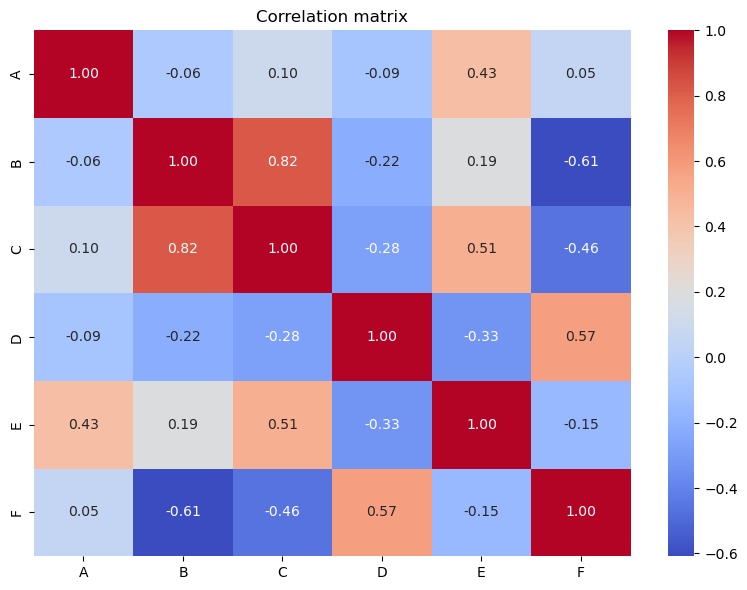

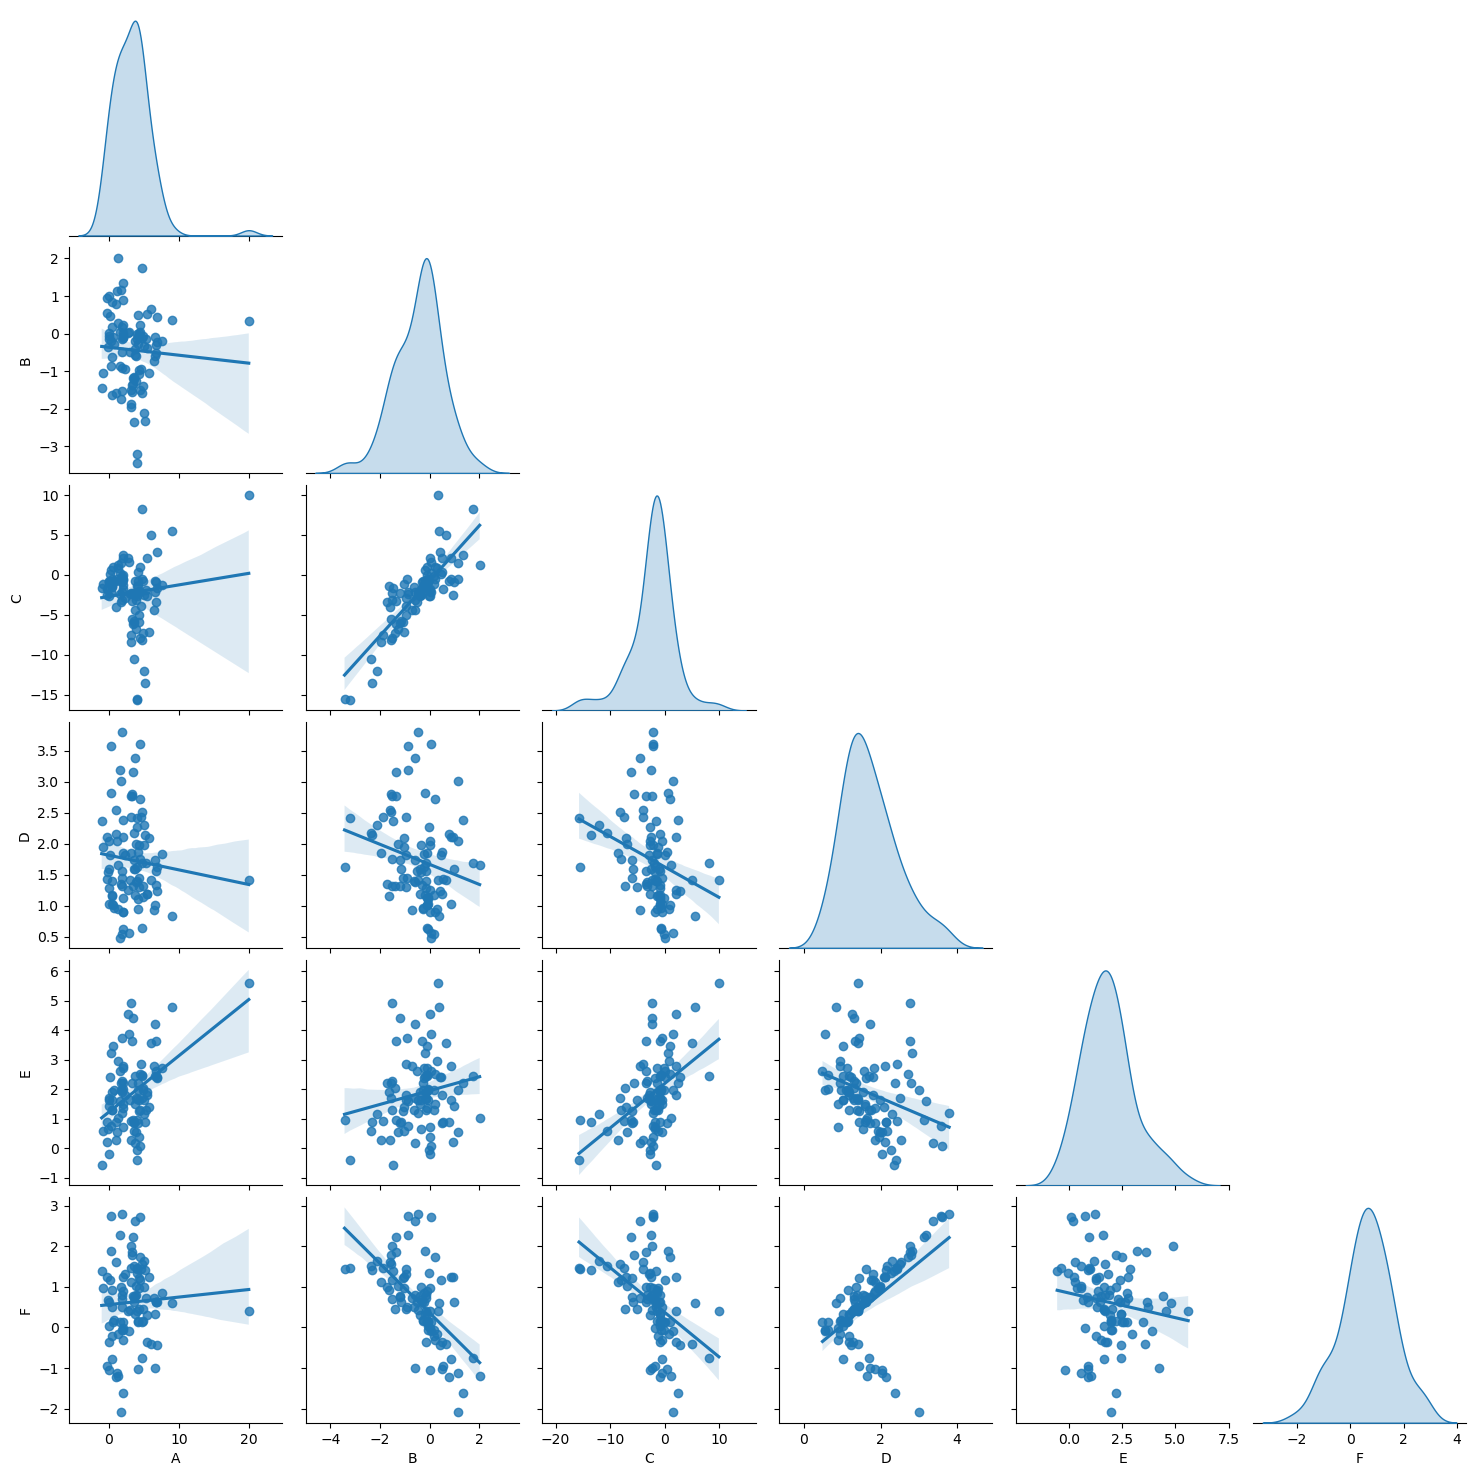

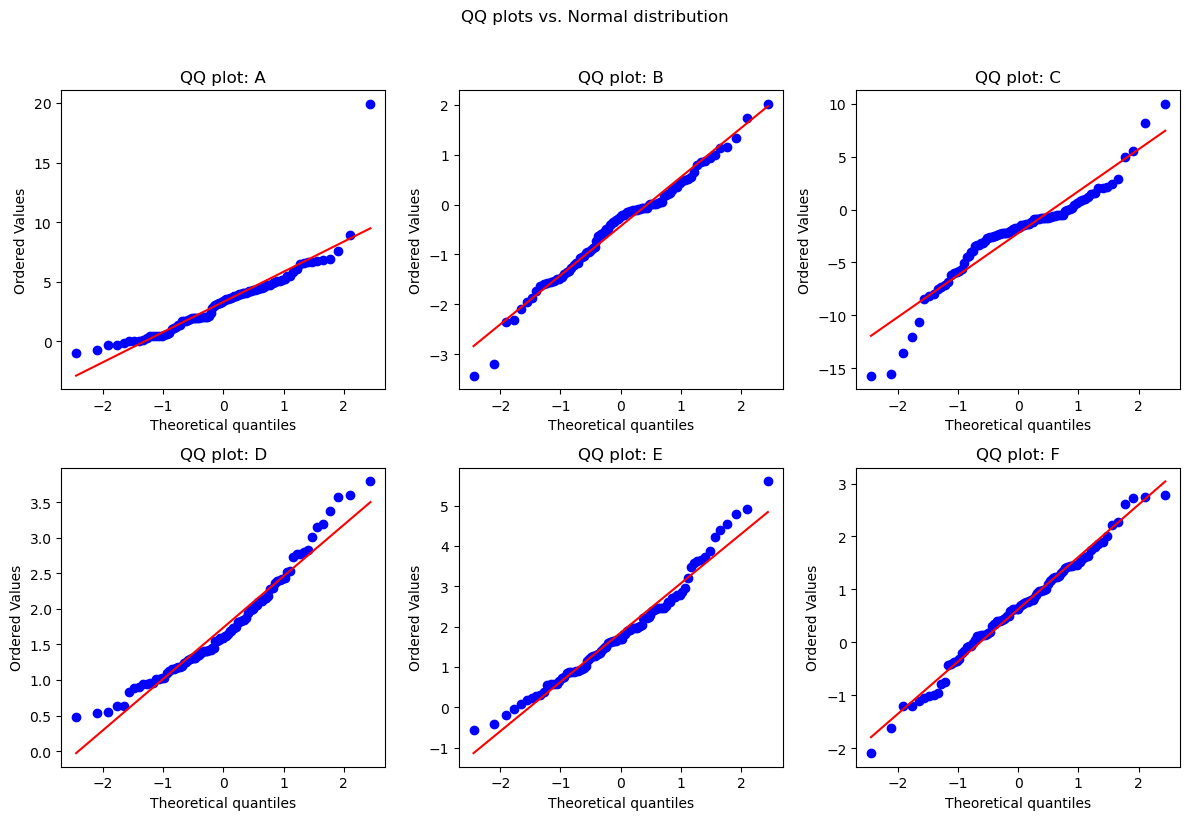

In [3]:
baseline = read('data_1901.csv')

plotCorrelation(baseline)

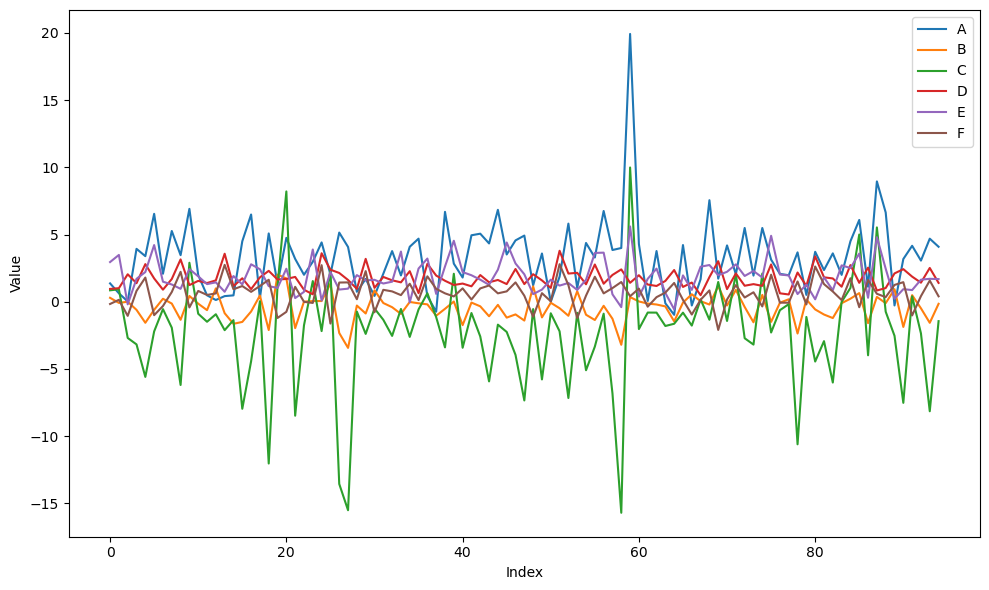

In [6]:
plotData(baseline)

In [16]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783
